In [11]:
%matplotlib inline

In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os
import os.path as osp

from tools.lib import makedirs, lighten_color, load_raw_data, load_raw_data_adv, get_all_results
from tools.functional import get_kappa_function
from tools.rotate import cart2sph, SphericalRotation3d
from tools.plot import plot_trajectory, axisEqual3D
from configs import PATHS, ADV_PATHS, CLASS_NAMES

from embeddings import RegionEmbedding
from embeddings.utils import get_region_cos_mat, get_region_prob_mat

**Setup dataset name, DNN architecture *etc.***

In [13]:
dataset = "TinyImagenet"
arch = "vgg16"
feature_layer = "conv_53"
adv_args = "pgd_inf_0.1_1_50_adv_all"
max_adv_iter = 20
result_folder = "./saved-results"
kappa_fn = get_kappa_function("./.cache/sample/kappa_max=10.0_dim=3.bin")

**Load some raw data**

In [14]:
images, logits_before = load_raw_data(
    PATHS=PATHS, dataset=dataset, arch=arch,
    data_names=["images", "logits"], device=torch.device("cpu")
)
logits_after, = load_raw_data_adv(ADV_PATHS, dataset, arch, adv_args, max_adv_iter, ["logits"], torch.device("cpu"))
images = images.numpy()
class_names = CLASS_NAMES[dataset]
sample_emb, sample_trans, class_direction, W_region, W_kernel, region_emb, region_trans = get_all_results(result_folder, dataset, arch, feature_layer="conv_53")
class_direction = torch.from_numpy(class_direction).float()
n_samples, n_regions = W_region.shape

**Load the transform $h^{(r)}=\Lambda f^{(r)}$**

In [15]:
transform = RegionEmbedding(in_dim=512, out_dim=3, device=torch.device("cpu"))
transform.load_state_dict(region_trans)

[RegionEmbedding] Finish initializing the transform.


<All keys matched successfully>

**Get regional embeddings throughout the attack based on the transformation above**

In [16]:
trajectory = []
trajectory_prob = []
trajectory_cos = []
for adv_iter in range(0, max_adv_iter, 2):
    print(f"iter {adv_iter}")

    regional_features, = load_raw_data_adv(
        ADV_PATHS, dataset, arch, adv_args, adv_iter,
        data_names=[f"{feature_layer}_features"], device=torch.device("cpu")
    )

    region_embs = transform.get_emb(regional_features).numpy()
    region_cos = get_region_cos_mat(region_embs=region_embs, class_direction=class_direction)
    region_prob = get_region_prob_mat(region_embs=region_embs, class_direction=class_direction, kappa_fn=kappa_fn)

    trajectory.append(region_embs.copy())
    trajectory_prob.append(region_prob.copy())
    trajectory_cos.append(region_cos.copy())

trajectory = np.stack(trajectory, axis=0)
trajectory_prob = np.stack(trajectory_prob, axis=0)
trajectory_cos = np.stack(trajectory_cos, axis=0)

iter 0
iter 2
iter 4
iter 6
iter 8
iter 10
iter 12
iter 14
iter 16
iter 18


**Setup colors, angles *etc.* for visualization**

In [17]:
# setup the colors
BlueRed = LinearSegmentedColormap.from_list(name="a", colors=[(0, 'blue'), (1, 'red')])
cmaps = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
cmaps = [LinearSegmentedColormap.from_list(name=c, colors=[(0, '#ffffff'), (1, lighten_color(c, amount=1.2))]) for c in cmaps]
# attack from the 5-th category (dog) to the 3-rd category (cat)
ori_category = 5
adv_category = 3
# for adjusting the angle for visualization
_, azim, elev = cart2sph(*class_direction[ori_category])
rotate = SphericalRotation3d(azim=-azim, elev=-elev)
_, azim, elev = cart2sph(*rotate(class_direction)[adv_category])

**Visualize attacking behaviours of four typical types**

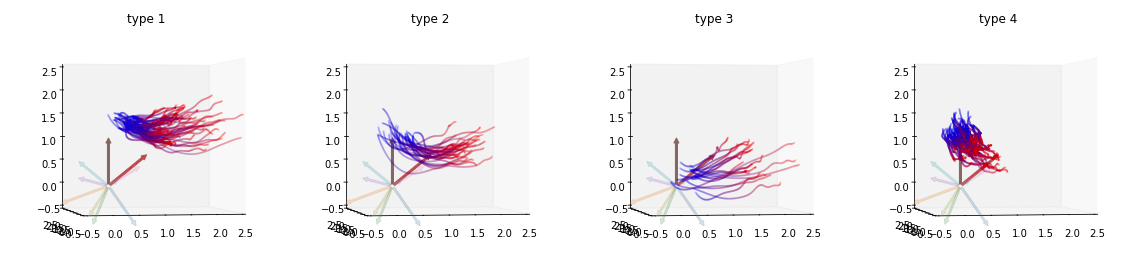

In [22]:
fig = plt.figure(figsize=(16, 4))
axs = {adv_type: fig.add_subplot(1, 4, adv_type, projection="3d") for adv_type in [1, 2, 3, 4]}

# plot each category direction
for adv_type in axs.keys():
    axs[adv_type].grid(False)
    axs[adv_type].set_title(f"type {adv_type}")
    axs[adv_type].set_xlim(-0.5, 2.5)
    axs[adv_type].set_ylim(-0.5, 2.5)
    axs[adv_type].set_zlim(-0.5, 2.5)
    axs[adv_type].view_init(azim=azim - 90, elev=0)
    for class_idx in range(10):  # for all class draw the class direction, generate the legend
        colors = plt.get_cmap(cmaps[class_idx])
        axs[adv_type].scatter([], [], [], color=colors(0.8), s=20, label=class_names[class_idx])  # generate the legend
        alpha = 1.0
        if class_idx not in [ori_category, adv_category]:
            alpha = 0.2
        axs[adv_type].arrow3D(0, 0, 0, *(rotate(class_direction)[class_idx]), mutation_scale=10, fc=colors(0.8), ec=colors(0.8), alpha=alpha)  # plot the class direction

# plot 4 types of attacking behaviours
high_prob_threshold = 0.5
reach_origin_threshold = 1.0
far_origin_threshold = 1.2
high_cos_threshold = 0.9
high_strength_threshold = 1.0
low_strength_threshold = 0.5

for sample_idx in range(n_samples):
    label_before_att = logits_before[sample_idx].argmax()
    label_after_att = logits_after[sample_idx].argmax()

    if label_before_att == label_after_att: continue  # the attack fails
    if label_before_att != ori_category or label_after_att != adv_category: continue

    for region_idx in range(n_regions):
        # TYPE I -- ori feature -> adv feature (do not reach origin)
        before_ori_feature = trajectory_cos[0, sample_idx, region_idx, ori_category] > high_cos_threshold and \
                             np.linalg.norm(trajectory[0, sample_idx, region_idx]) > high_strength_threshold
        not_reach_origin = np.linalg.norm(trajectory[:, sample_idx, region_idx], axis=1).min() > far_origin_threshold
        after_adv_feature = trajectory_prob[-1, sample_idx, region_idx, adv_category] > high_prob_threshold
        before_not_too_long = np.linalg.norm(trajectory[0, sample_idx, region_idx]) < 1.5  # for visualization clarity
        if before_ori_feature and before_not_too_long and not_reach_origin and after_adv_feature:
            plot_trajectory(axs[1], rotate(trajectory[:, sample_idx, region_idx]), cmap=BlueRed)

        # TYPE II -- ori feature -> no feature -> adv feature (reach origin)
        before_ori_feature = trajectory_cos[0, sample_idx, region_idx, ori_category] > high_cos_threshold and \
                             np.linalg.norm(trajectory[0, sample_idx, region_idx]) > high_strength_threshold
        reach_origin = np.linalg.norm(trajectory[:, sample_idx, region_idx], axis=1).min() < reach_origin_threshold
        after_adv_feature = trajectory_prob[-1, sample_idx, region_idx, adv_category] > high_prob_threshold
        if before_ori_feature and after_adv_feature and reach_origin:
            plot_trajectory(axs[2], rotate(trajectory[:, sample_idx, region_idx]), cmap=BlueRed)

        # TYPE III -- no feature -> adv feature
        before_no_feature = np.linalg.norm(trajectory[0, sample_idx, region_idx]) < low_strength_threshold
        after_adv_feature = trajectory_prob[-1, sample_idx, region_idx, adv_category] > high_prob_threshold
        if before_no_feature and after_adv_feature:
            plot_trajectory(axs[3], rotate(trajectory[:, sample_idx, region_idx]), cmap=BlueRed)

        # TYPE IV -- ori feature -> no feature
        before_ori_feature = trajectory_cos[0, sample_idx, region_idx, ori_category] > high_cos_threshold and \
                             np.linalg.norm(trajectory[0, sample_idx, region_idx]) > high_strength_threshold
        after_no_feature = np.linalg.norm(trajectory[-1, sample_idx, region_idx]) < reach_origin_threshold
        if before_ori_feature and after_no_feature:
            plot_trajectory(axs[4], rotate(trajectory[:, sample_idx, region_idx]), cmap=BlueRed)

for adv_type in axs.keys():
    axisEqual3D(axs[adv_type])


plt.tight_layout()
plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.show()